In [1]:
import pandas as pd
import numpy as np 
import imblearn as ibl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from utils import selecionar_melhor_k_knn, do_cv_knn

# Atributos Categóricos e Valores Faltantes

## Atributos Categóricos

Algumas bases de dados contém atributos categóricos. Os valores destes atributos não assumem valores numéricos.  Exemplos de atributos categóricos incluem: "genero" que pode assumir os valores "masculino", "feminino" ou "outros"; "cargo" que pode assumir os valores "executivo", "gerente" ou "técnico"; entre outros. Como os valores não são numéricos é impossível representar *diretamente* instâncias que contém atributos categóricos em um espaço euclidiano de características ($\mathbb{R}^n$). Como consequência, não é possível usar métodos de classificação que operam no espaço euclidiano (como o KNN) em bases de dados com atributos categóricos. Nesta aula vamos aprender algumas formas de transformar atributos categóricos em atributos numéricos, possibilitando a construção de modelos que operam no espaço euclidiano.

Nesta aula vamos usar um subconjunto dos atributos da base de dados *employee*. As instâncias dessa base de dados representam vários empregados de uma empresa. Os atributos de entrada descrevem alguns dados coletados sobre os empregados, como avaliações, horas trabalhadas e informações sobre promoções, acidentes de trabalho, departamento e faixa salarial. O atributo de saída (*left*) indica se o empregado deixou a empresa. Estamos deixando alguns atributos de fora para dificultar um pouco o problema de classificação.

In [2]:
df = pd.read_csv('employee.csv')
#deixar apenas as 4 ultimas colunas (3 atributos de entrada + 1 de saída)
df.drop(df.columns[:-4:1], axis=1, inplace=True)
#converter y para numpy array 1d
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,promotion_last_5years,department,salary,left
0,0,sales,low,1
1,0,sales,medium,1
2,0,sales,medium,1
3,0,sales,low,1
4,0,sales,low,1
...,...,...,...,...
14994,0,support,low,1
14995,0,support,low,1
14996,0,support,low,1
14997,0,support,low,1


### Codificação Ordinal

O mapeamento dos valores de atributos categóricos em valores numéricos é denominado **codificação**. A forma mais simples de codificação é a *codificação ordinal*.  Neste esquema, cada valor recebe um código numérico inteiro que o representa. Por exemplo, vamos supor um atributo categórico "cor" que pode assumir os valores "vermelho", "verde", "azul" ou "roxo". Em uma codificação categórica, poderíamos associar cada valor com um código numérico: "vermelho" $\to$ 0, "verde" $\to$ 1, "azul" $\to$ 2 e "roxo" $\to$ 3. Assim, todas as instâncias que tiverem o valor "vermelho" para o atributo "cor" passsam a representá-lo como 0, as instâncias com "cor" = "verde" passam a representá-lo como 1, e assim por diante.

O ``sklearn`` oferece a classe ``OrdinalEncoder`` que faz essa codificação automaticamente.

In [3]:
#Vamos usar o ColumnTransformer para combinar vários encoders em um único "codificador"
#No exemplo inicial, vamos usar OrdinalEncoder para codificar 2 atributos. Entretanto,
#vários encoders diferenes podem ser usados em um único ColumnTransformer, como veremos adiante.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [4]:
#A idéia é que o ColumnTransform é construído como uma lista de "transformers". No 
#sklearn as classes que tem os métodos "transfom", como OrdinalEncoder, PCA, StandardScaler, etc,
#são considerados transformers.

#Cada elemento da lista é uma tupla (nome, transformer, lista_de_colunas) que codifica quais colunas (do pandas dataframe)
#serão codificadas com aquele transformador. "nome" é usado em algumas outras operações que veremos mais adiante.
transformers = [
    ('oe_department', OrdinalEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
]

#construir o transformer de acordo com a lista de transformadores.
#O atributo remainder indica o que fazer com os atributos que não foram listados na lista de transformer.
#"passthrough" indica que esses atributos devem ser apenas copiados para a saída, sem alterações.
ct = ColumnTransformer(
    transformers, remainder='passthrough'
)
#Deduzir todos os códigos dos encoders e já fazer a codificação. É importante ressaltar que a saída é um numpy.ndarray,
#e não um pandas DataFrame.
X_oe = ct.fit_transform(X)
#Imprime as categorias do transformer 0. Note que como "IT" está na primeira posição, ele é o código 0,
#RandD é código 1, e assim por diante.
print(ct.transformers_[0][1].categories_)

[array(['IT', 'RandD', 'accounting', 'hr', 'management', 'marketing',
       'product_mng', 'sales', 'support', 'technical'], dtype=object)]


Note que fizemos a codificação dos atributos categóricos de todas as instâncias da base de dados em conjunto, sem a separação entre conjunto de treinamento e teste. Neste caso não é um problema, uma vez que apenas estamos convertendo a base de dados para uma versão equivalente, sem atributos categóricos. Entretanto, caso queira codificar mais dados, como no caso de usar o modelo em dados do mundo real, basta usar o método ``ct.transform``.

In [5]:
accs = do_cv_knn(X_oe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.69, max: 0.76, avg +- std: 0.74+-0.02


Os atributos que possuem uma relação de ordem intrínseca, como é o caso do atributo *salary* acima, cujos valores "low", "medium" e "high" representam a ordem crescente de salários são bons candidatos a serem codificados por um codificador ordinal. Por isso, não é surpreendente que tais atributos sejam denominados *atributos ordinais*. Note que as categorias foram passadas explicitamente ao construtor: ``OrdinalEncoder(categories=[['low', 'medium', 'high']])``, indicando a ordem das categorias. Desta forma, "low" $\to$ 0, "medium" $\to$ 1 e "high" $\to$ 2.

Embora a codificação ordinal seja simples e fácil de entender, ela não é adequada para codificar qualquer tipo de atributo categórico. Isto porque alguns algoritmos de aprendizagem de máquina consideram que suas entradas são contínuas, e, por consequencia, considerariam que as categorias (valores do atributo categórico) como ordenadas. Isto não faz sentido para alguns atributos. Por exemplo, alguns algoritmos de aprendizagem de máquina poderiam considerar os valores do atributo *department* podem ter uma relação de ordem. Entretanto, esta relação não existe: queremos apenas diferenciar departamentos diferentes que os empregados podem estar vinculados. Atributos que não apresentam uma relação de ordem, como *department*, são chamados de *atributos nominais*, e normalmente usam outra codificação, como *One-Hot encoding*, que veremos a seguir. 

### One-Hot Encoding (dummy variable encoding)

Neste esquema de codificação, um atributo categórico com $n$ categorias é codificado em $n$ atributos binários, um deles com valor 1, que representa o valor do atributo para aquela instância, e os demais com valor 0. A Figura abaixo mostra um exemplo de codificação one-hot:

<div align='center'>
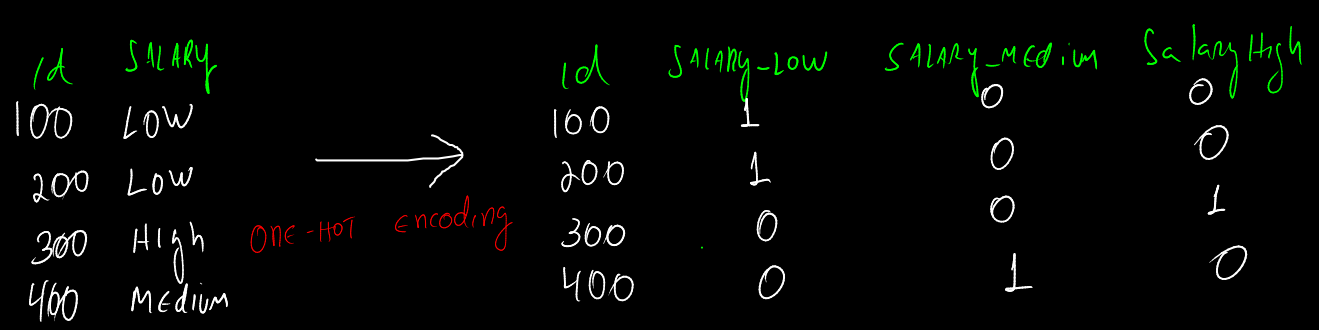
</div>

Note como a coluna *salary* foi codificada em três colunas, uma para cada categoria: *salary_low*, *salary_medium* e *salary_high*. Este esquema de codificação é adequado para atributos nominais, como o atributo *department* do exemplo.

O ``sklearn`` oferece a classe ``OneHotEncoder``  que implementa esta codificação.

In [7]:
from sklearn.preprocessing import OneHotEncoder

transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oh_salary', OneHotEncoder(), ['salary']),
]

ct_oh = ColumnTransformer(
    transformers, remainder='passthrough'
)

#O sklearn detecta que esta codificação pode levar a uma matriz esparsa (com muitos zeros). Entretanto, em nosso modelo
#estamos supondo que a matriz é densa. O método todense da classe numpy.ndarray serve para obter a matriz de saída como
#uma matriz densa ao invés de uma matriz esparsa.
X_oh = ct_oh.fit_transform(X).todense()

In [8]:
ct_oh.get_feature_names(), X_oh.shape, X.shape

(['oh_department__x0_IT',
  'oh_department__x0_RandD',
  'oh_department__x0_accounting',
  'oh_department__x0_hr',
  'oh_department__x0_management',
  'oh_department__x0_marketing',
  'oh_department__x0_product_mng',
  'oh_department__x0_sales',
  'oh_department__x0_support',
  'oh_department__x0_technical',
  'oh_salary__x0_high',
  'oh_salary__x0_low',
  'oh_salary__x0_medium',
  'promotion_last_5years'],
 (14999, 14),
 (14999, 3))

Note os nomes dos atributos após a codificação one-hot. Veja que um atributo foi criado para cada categoria dos atributos *department* e *salary*. Com isto, a dimensionalidade do vetor de características passou de 3 pra 14. Por consequência, a validação cruzada demorará mais para executar:

In [9]:
accs = do_cv_knn(X_oh, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.73, max: 0.76, avg +- std: 0.75+-0.01


Note que o resultado obtido usando apenas codificação ordinal ($0.74 \pm 0.02$) foi muito semelhante ao resultado no qual codificamos os atributos usando apenas codificação one-hot ($0.75 \pm 0.01$). Na aula que vem iremos aprender como comparar modelos para descobrir se a diferença nos resultados é estatisticamente significativa.

A seguir vamos verificar o que acontece com essa base de dados, se usarmos encoders diferentes para cada atributo.

### Combinando *encoders* diferentes

Conforme foi discutido acima, é recomendado usar codificação one-hot para atributos nominais e codificação ordinal para atributos ordinais. Usando ``ColumnTransformer`` é bem simples aplicar codificadores diferentes em colunas diferentes.

In [11]:
#Note que agora estamos usando OneHotEncoder para codificar o departamento e 
# OrdinalEncoder para codificar as faixas salariais
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_ohoe = ct_ohoe.fit_transform(X).todense()

In [12]:
X_ohoe.shape, X.shape

((14999, 12), (14999, 3))

Desta vez o número de atributos passou de 3 para 12.

In [13]:
accs = do_cv_knn(X_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.73, max: 0.76, avg +- std: 0.75+-0.01


Nesta base de dados o resultado obtido codificando os atributos categóricos com encoders apropriados não foi muito diferente dos resultados obtidos com as duas outras estratégias que avaliamos. Entretanto, isto nem sempre acontece. É importante avaliar diferentes combinações de técnicas de codificação de atributos categóricos para obter melhores resultados.

# Valores Faltantes

Não é incomum trabalhar com bases de dados que contenham instâncias com valores desconhecidos para alguns atributos. Nesta aula vamos estudar algumas técnicas simples para lidar com valores faltantes.

Usaremos novamente um subconjunto de atributos da base de dados *employee*. Entretanto, desta vez vamos usar uma versão dessa base de dados que contém instâncias com valores faltantes para alguns atributos.

In [19]:
df = pd.read_csv('employee_nans.csv')
df.drop(df.columns[:-4:1], axis=1, inplace=True)
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,promotion_last_5years,department,salary,left
0,0.0,sales,low,1
1,0.0,sales,medium,1
2,0.0,sales,medium,1
3,0.0,sales,low,1
4,0.0,sales,low,1
...,...,...,...,...
14994,0.0,support,low,1
14995,0.0,support,low,1
14996,0.0,support,low,1
14997,0.0,support,low,1


Note que os valores faltantes são representados como *NaN* (*not a number*) pelo pandas. Estes valores são iguais a ``np.nan``.

Para verificar rapidamente se há algum valor faltante no DataFrame basta:

In [20]:
#retorna a quantidade de valores faltantes no dataframe
df.isnull().sum().sum()

2279

Note que há 2279 valores faltantes na base de dados.

## Exclusão das instâncias com valores faltantes

A estratégia mais simples para lidar com valores faltantes é simplesmente ignorar todas as instâncias que contenham pelo menos um valor faltante.

In [21]:
print("shape da base de dados antes de excluir as instâncias com valores faltantes: %s" % (str(df.shape)))
df.dropna(inplace=True)

y = df[['left']].values.ravel()
X = df.drop('left', axis=1)

print("shape da base de dados APÓS excluir as instâncias com valores faltantes: %s" % (str(df.shape)))

df.isnull().sum().sum()

shape da base de dados antes de excluir as instâncias com valores faltantes: (14999, 4)
shape da base de dados APÓS excluir as instâncias com valores faltantes: (12815, 4)


0

Lembrando que 2 dos 3 atributos são categóricos, é necessário fazer a codificação para valores numéricos usando codificação *one-hot* para o atributo nominal (*department*) e codificação ordinal para o atributo ordinal (*salary*).

In [23]:
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_ohoe = ct_ohoe.fit_transform(X).todense()
accs = do_cv_knn(X_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.66, max: 0.76, avg +- std: 0.74+-0.03


Na prática a exclusão de instâncias que contenham atributos faltantes não permite realizar predições de novas instâncias que contenham atributos faltantes. Uma alternativa é substituir valores faltantes por algum valor que seja adequado, tanto nas instâncias de treinamento quanto nas instâncias de teste.

## Substituição de valores faltantes (Imputação)

Outra estratégia usada para lidar com valores faltantes é simplesmente substituir os valores faltantes por algum outro valor. Esta substituição também é conhecida como **imputação**. Existem muitas formas de fazer a imputação e a forma adequada depende de muitos fatores. Hoje vamos estudar estratégias *univariadas*, ou seja, os valores imputados dependem somente do próprio atributo. Em constraste, também existem estratégias *multivariadas*, que são usadas para estimar um valor faltante em função dos valores de outros atributos.

Lembre-se que os algoritmos de aprendizagem necessitam de atributos numéricos, e que o valor que representa valores desconhecidos, NaN, não é numérico. Assim, a imputação é um passo fundamental para lidar com valores faltantes.

In [57]:
df = pd.read_csv('employee_nans.csv')
df.drop(df.columns[:-4:1], axis=1, inplace=True)
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,promotion_last_5years,department,salary,left
0,0.0,sales,low,1
1,0.0,sales,medium,1
2,0.0,sales,medium,1
3,0.0,sales,low,1
4,0.0,sales,low,1
...,...,...,...,...
14994,0.0,support,low,1
14995,0.0,support,low,1
14996,0.0,support,low,1
14997,0.0,support,low,1


In [26]:
df.isnull().sum().sum()

2279

Uma estratégia de imputação comum para atributos numéricos é substituir valores desconhecidos por alguma estatística calculada sobre os valores não-faltantes do mesmo atributo. Estatísticas comuns são a média, a mediana e o valor mais frequente. Este tipo de estratégia é mais comumente usada para imputar valores faltantes a atributos numéricos.

A estratégia mais simples de imputação consiste em substituir todos os valores desconhecidos por um valor constante. Esta estratégia é bastante utilizada para imputar valores em atributos categóricos, uma vez que as estratégias baseadas em estatística descritiva não são aplicáveis nestes atributos. Entretanto a substituição por valor constante também pode ser usada para atributos numéricos.

A biblioteca ``sklearn`` oferece a classe ``SimpleImputer``, que já implementa várias estratégias univariadas para imputação de valores faltantes.

In [58]:
from sklearn.impute import SimpleImputer

atributos_numericos = ['promotion_last_5years']
atributos_categoricos = ['department', 'salary']

#Vamos usar a estratégia de imputar a média no lugar de valores faltantes para o atributo promotion_last_5years.
#Para isso, indicamos strategy="mean" para o construtor do SimpleImputer.
#Para os atributos categóricos, vamos apenas substituir os valores faltantes por "desconhecido".
#Para isso, indicamos strategy="constant" e fill_value="desconhecido".
transformers = [
    ('imp_num', SimpleImputer(strategy='mean'), atributos_numericos),
    ('imp_cat', SimpleImputer(strategy='constant', fill_value='desconhecido'), atributos_categoricos)
]
#Para simplificar, vamos usar o ColumnTransformer para aplicar a imputação nos atributos numéricos e categóricos "de uma vez"
#Note que estamos usando a MESMA INSTÂNCIA do SimpleImputer para ambos atributos_categoricos, uma vez que queremos
#substituir qualquer valor faltante por 'desconhecido'. Caso quisessemos atribuir valores diferentes para representar os desconhecidos
#precisariamos de duas instâncias separadas.

ct_imp = ColumnTransformer(
    transformers, remainder='drop'
)

X_imp_vals = ct_imp.fit_transform(X)

In [62]:
#Lembre-se que fit_transform retorna um numpy.ndarray. 
#Se quisermos um dataframe novamente, precisamos construí-lo.
X_imputed = pd.DataFrame(X_imp_vals, columns=[*atributos_numericos, *atributos_categoricos])

In [63]:
#Verificando se existe algum valor faltante no novo dataframe.
X_imputed.isnull().sum().sum()

0

Lembrando que 2 dos 3 atributos são categóricos, é necessário fazer a codificação para valores numéricos usando codificação *one-hot* para o atributo nominal (*department*) e codificação ordinal para o atributo ordinal (*salary*).

In [74]:
#Note como ainda decidi usar OrdinalEncoder para salary, mesmo com o valor "desconhecido", que não 
#tem relação de ordem como os demais valores. Esta escolha foi arbitrária. O ideal é testar diferentes abordagens
#e escolher aquela com o melhor resultado.
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['desconhecido', 'low', 'medium', 'high']]), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_imputed_ohoe = ct_ohoe.fit_transform(X_imputed).todense()

In [75]:
accs = do_cv_knn(X_imputed_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [76]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.76, max: 0.76, avg +- std: 0.76+-0.00


## Valores Faltantes e Validação Cruzada

O exemplo com a estratégia de imputação acima não está metodologicamente correto. Isto resulta do fato que usamos a base de dados *inteira* para estimar a média do atributo *promotion_last_5years* para fazer a imputação. Com isto, foram usados dados do conjunto de teste, o que "vaza" informações do conjunto de teste no modelo. O ideal é realizar o cálculo das estatísticas que serão usadas na imputação no conjunto de treinamento, e somente aplicá-la no conjunto de testes. O código abaixo leva este detalhe em consideração. Além disto, como no processo de validação cruzada o conjunto de treinamento e testes é diferente em cada rodada, é importante que a imputação seja realizada novamente em cada rodada da validação cruzada.


In [92]:
from tqdm.notebook import tqdm

#Esta função recebe os atributos das instâncias de treinamento e de teste. As estatísticas para a imputação são
#calculadas sobre o conjunto de treinamento, e apenas aplicadas no conjunto de testes.
def imputar_dados(X_treino, X_teste):
    atributos_numericos = ['promotion_last_5years']
    atributos_categoricos = ['department', 'salary']
    
    transformers = [
        ('imp_num', SimpleImputer(strategy='mean'), atributos_numericos),
        ('imp_cat', SimpleImputer(strategy='constant', fill_value='desconhecido'), atributos_categoricos),
    ]
    
    ct = ColumnTransformer(
        transformers, remainder='drop'
    )
    
    #Calcular a estatística para a imputação e transformar o conjunto de treinamento
    X_imputed_treino = ct.fit_transform(X_treino)
    #Construir o dataframe do conjunto de treinamento, agora com dados imputados.
    X_imputed_treino = pd.DataFrame(X_imputed_treino, columns=[*atributos_numericos, *atributos_categoricos])
    
    #Aplicar a estatística obtida a partir do conjunto de treinamento no conjunto de testes
    X_imputed_teste = ct.transform(X_teste)
    #Construir o dataframe do conjunto de testes, agora com dados imputados.
    X_imputed_teste = pd.DataFrame(X_imputed_teste, columns=[*atributos_numericos, *atributos_categoricos])
    
    return X_imputed_treino, X_imputed_teste

def codificar_categoricas(X_treino, X_teste):
    
    transformers = [
        ('oh_department', OneHotEncoder(), ['department']),
        ('oe_salary', OrdinalEncoder(categories=[['desconhecido', 'low', 'medium', 'high']]), ['salary']),
    ]

    ct = ColumnTransformer(
        transformers, remainder='passthrough'
    )
    X_treino_ = ct.fit_transform(X_treino).todense()
    X_teste_ = ct.transform(X_teste).todense()
    
    return X_treino_, X_teste_
    

In [93]:
def do_cv_knn_imputer(X, y, cv_splits, ks, imputer=None, encoder=None):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        if isinstance(X, pd.DataFrame):
            X_treino = X.iloc[treino_idx]
            X_teste = X.iloc[teste_idx]
            
            if imputer is not None:
                X_treino, X_teste = imputer(X_treino, X_teste)            

            if encoder is not None:
                X_treino, X_teste = encoder(X_treino, X_teste)    
            else:
                X_treino = X_treino.values
                X_teste = X_teste.values   
        else:
            X_treino = X[treino_idx]
            X_teste = X[teste_idx]
            
        y_treino = y[treino_idx]
        y_teste = y[teste_idx]
        
        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        knn, _, _ = selecionar_melhor_k_knn(ks, X_treino, X_val, y_treino, y_val)
        pred = knn.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
    
    pgb.close()
    
    return acuracias


In [94]:
df = pd.read_csv('employee_nans.csv')
df.drop(df.columns[:-4:1], axis=1, inplace=True)
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,promotion_last_5years,department,salary,left
0,0.0,sales,low,1
1,0.0,sales,medium,1
2,0.0,sales,medium,1
3,0.0,sales,low,1
4,0.0,sales,low,1
...,...,...,...,...
14994,0.0,support,low,1
14995,0.0,support,low,1
14996,0.0,support,low,1
14997,0.0,support,low,1


In [95]:
accs = do_cv_knn_imputer(X, y, 10, range(1,20,2), imputar_dados, codificar_categoricas)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [96]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.76, max: 0.76, avg +- std: 0.76+-0.00


Não houve diferença no desempenho obtido fazendo a imputação adequada dos atributos numéricos usando apenas o conjunto de treinamento, quando comparado ao resultado anterior. Entretanto, em datasets mais complexos pode haver diferença significativa. Mesmo que o resultado obtido seja inferior com o método apresentado por último, é importante usá-lo para avaliar a generalização apropriadamente.